# FLoW-Net Workshop

1. Data generation with PyWake
2. Rasterization
3. Normalization
4. Model architecture
5. Training
6. Evaluation

## 1. Setup

In [18]:
!git clone https://github.com/FPWRasmussen/AI_workshop.git .
!pip install -r requirements.txt

fatal: destination path '.' already exists and is not an empty directory.


In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.workshop_utils import (
    ARUNet, generate_sample, generate_layout, rasterize_turbines,
    normalize_labels, log_normalize_output, inverse_log_normalize,
    prepare_batch, predict, compute_metrics, load_model
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## 2. Data Generation

We generate wind farm layouts using:
1. **Random polygon** for farm boundary
2. **Poisson disk sampling** to place turbines with minimum spacing
3. **PyWake** to simulate wake effects

In [20]:
# Generate a sample with downstream wake observation
sample = generate_sample(
    wind_speed=10.0,
    turbulence_intensity=0.06,
    farm_area=6000,      # Farm area in D²
    spacing=6.0,         # Min turbine spacing in D
    x_range=(-128, 384), # Domain: upstream to far downstream
    y_range=(-128, 128),
    resolution=(256, 128)
)

print(f"Turbines: {len(sample['turbine_positions'])}")
print(f"Flow map shape: {sample['flow_map'].shape}")
print(f"Wind speed: {sample['labels'][0]:.1f} m/s")

Turbines: 111
Flow map shape: (128, 256)
Wind speed: 10.0 m/s


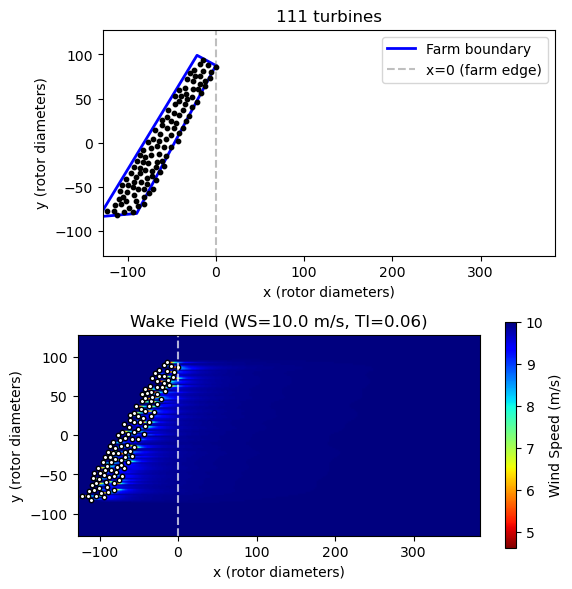

In [21]:
# Visualize the layout and wake field
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
positions = sample['turbine_positions']
polygon = sample['polygon']

# Layout with polygon boundary
ax = axes[0]
if polygon is not None:
    x_poly, y_poly = polygon.exterior.xy
    # Shift polygon to match turbine shift
    x_shift = positions[:, 0].max() - np.max(x_poly)
    ax.plot(np.array(x_poly) + x_shift, y_poly, 'b-', linewidth=2, label='Farm boundary')
ax.scatter(positions[:, 0], positions[:, 1], s=10, c='black', zorder=5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, label='x=0 (farm edge)')
ax.set_xlim(sample['x_coords'][0], sample['x_coords'][-1])
ax.set_ylim(sample['y_coords'][0], sample['y_coords'][-1])
ax.set_xlabel('x (rotor diameters)')
ax.set_ylabel('y (rotor diameters)')
ax.set_title(f'{len(positions)} turbines')
ax.legend()
ax.set_aspect('equal')

# Wake field
ax = axes[1]
im = ax.imshow(sample['flow_map'], origin='lower', cmap='jet_r', aspect='auto',
    extent=[sample['x_coords'][0], sample['x_coords'][-1], 
            sample['y_coords'][0], sample['y_coords'][-1]])
ax.scatter(positions[:, 0], positions[:, 1], s=10, c='white', edgecolor='black')
ax.axvline(0, color='white', linestyle='--', alpha=0.7)
ax.set_xlabel('x (rotor diameters)')
ax.set_ylabel('y (rotor diameters)')
ax.set_title(f'Wake Field (WS={sample["labels"][0]:.1f} m/s, TI={sample["labels"][1]:.2f})')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Wind Speed (m/s)')
plt.tight_layout()

## 3. Rasterization

Convert turbine (x, y) positions to a 2D grid using bilinear interpolation.

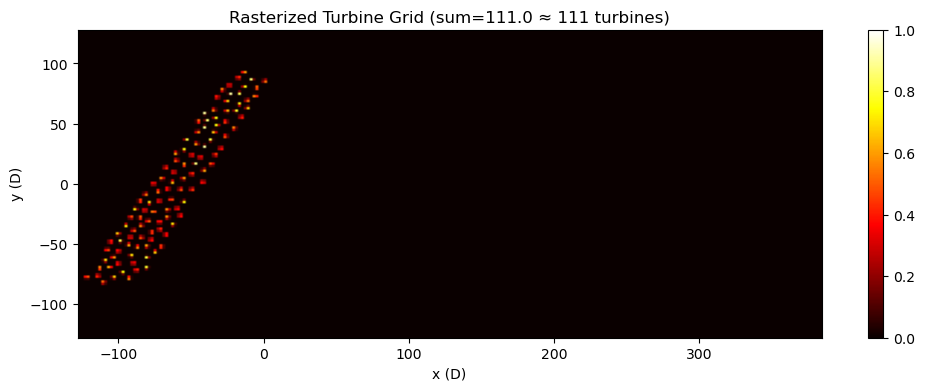

In [22]:
# Show the turbine grid
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(sample['grid'], origin='lower', cmap='hot', aspect='auto', vmin=0, vmax=1,
    extent=[sample['x_coords'][0], sample['x_coords'][-1], 
            sample['y_coords'][0], sample['y_coords'][-1]])
ax.set_xlabel('x (D)')
ax.set_ylabel('y (D)')
ax.set_title(f'Rasterized Turbine Grid (sum={sample["grid"].sum():.1f} ≈ {len(positions)} turbines)')
plt.colorbar(im, ax=ax)
plt.show()

## 4. Normalization

- **Labels**: Min-max to [0,1]
- **Output**: Log transform (wake deficits span orders of magnitude)

In [23]:
ws, ti = sample['labels']
labels_norm = normalize_labels(ws, ti)
print(f"Labels: WS={ws:.1f} → {labels_norm[0]:.3f}, TI={ti:.3f} → {labels_norm[1]:.3f}")

flow = sample['flow_map']
flow_norm = log_normalize_output(flow, ws)
flow_recovered = inverse_log_normalize(flow_norm, ws)
print(f"Output: [{flow.min():.2f}, {flow.max():.2f}] → [{flow_norm.min():.3f}, {flow_norm.max():.3f}]")
print(f"Recovery error: {np.abs(flow - flow_recovered).max():.6f} m/s")

Labels: WS=10.0 → 0.286, TI=0.060 → 0.136
Output: [4.61, 10.00] → [0.000, 0.946]
Recovery error: 0.000100 m/s


## 5. Model

In [24]:
model = ARUNet(
    in_channels=1, out_channels=1, num_extra_features=2,
    initial_channels=16, max_depth=3, use_film=True, use_se=True
).to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 169,544


## 6. Generate Training Data

In [25]:
print("Generating training data...")
train_samples = [generate_sample(
    wind_speed=np.random.uniform(6, 8),
    turbulence_intensity=np.random.uniform(0.04, 0.06),
    farm_area=np.random.uniform(1000, 3000),
    spacing=np.random.uniform(5, 7),
    x_range=(-128, 28),
    y_range=(-64, 64)
) for _ in range(50)]

print("Generating validation data...")
val_samples = [generate_sample(
    wind_speed=np.random.uniform(6, 8),
    turbulence_intensity=np.random.uniform(0.04, 0.06),
    farm_area=np.random.uniform(1000, 3000),
    spacing=np.random.uniform(5, 7),
    x_range=(-128, 28),
    y_range=(-64, 64)
) for _ in range(5)]

print(f"Train: {len(train_samples)}, Val: {len(val_samples)}")

Generating training data...
Generating validation data...
Train: 50, Val: 5


## 7. Training

In [26]:
train_g, train_o, train_l = prepare_batch(train_samples, normalize_output=True)
val_g, val_o, val_l = prepare_batch(val_samples, normalize_output=True)

train_g, train_o, train_l = train_g.to(device), train_o.to(device), train_l.to(device)
val_g, val_o, val_l = val_g.to(device), val_o.to(device), val_l.to(device)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    loss = criterion(model(train_g, train_l), train_o)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_losses.append(criterion(model(val_g, val_l), val_o).item())
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: train={train_losses[-1]:.5f}, val={val_losses[-1]:.5f}")

Epoch 5: train=0.04794, val=0.06479
Epoch 10: train=0.03013, val=0.05205
Epoch 15: train=0.02372, val=0.04354
Epoch 20: train=0.01922, val=0.03835


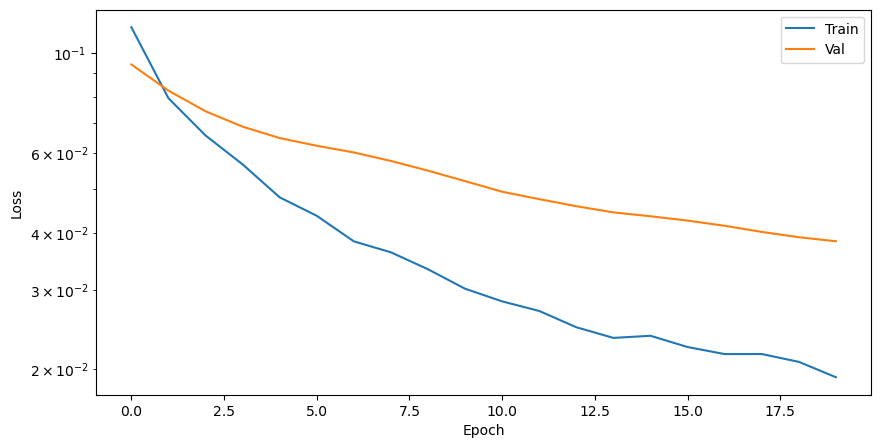

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

## 8. Evaluate

In [29]:
test = val_samples[0]
my_pred = predict(model, test, device)
my_m = compute_metrics(test['flow_map'], my_pred)
print(f"Your model: RMSE={my_m['rmse']:.3f}, R²={my_m['r2']:.3f}")

Your model: RMSE=0.402, R²=-0.183


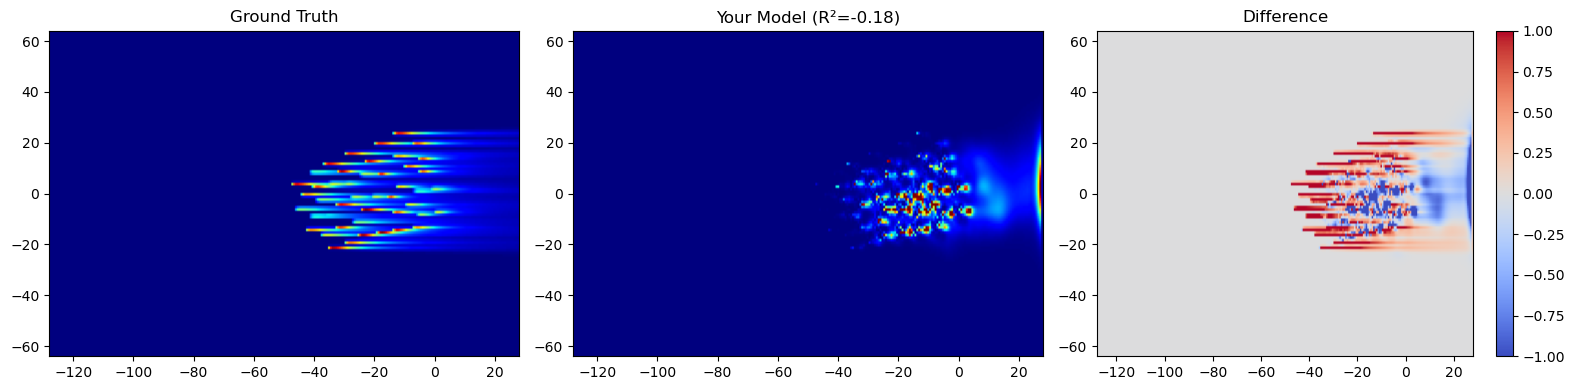

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = test['flow_map'].min(), test['flow_map'].max()
extent = [test['x_coords'][0], test['x_coords'][-1], test['y_coords'][0], test['y_coords'][-1]]

axes[0].imshow(test['flow_map'], origin='lower', cmap='jet_r', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
axes[0].set_title('Ground Truth')
axes[1].imshow(my_pred, origin='lower', cmap='jet_r', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
axes[1].set_title(f'Your Model (R²={my_m["r2"]:.2f})')
im = axes[2].imshow(my_pred - test['flow_map'], origin='lower', cmap='coolwarm', vmin=-1, vmax=1, aspect='auto', extent=extent)
axes[2].set_title('Difference')
plt.colorbar(im, ax=axes[2])
plt.tight_layout()

## 9. Compare with Pretrained

In [31]:
pretrained = load_model('models/best_model_Zong.pth', device)
pre_pred = predict(pretrained, test, device)
pre_m = compute_metrics(test['flow_map'], pre_pred)

print(f"Your model:  RMSE={my_m['rmse']:.3f}, R²={my_m['r2']:.3f}")
print(f"Pretrained:  RMSE={pre_m['rmse']:.3f}, R²={pre_m['r2']:.3f}")

Your model:  RMSE=0.402, R²=-0.183
Pretrained:  RMSE=0.277, R²=0.440


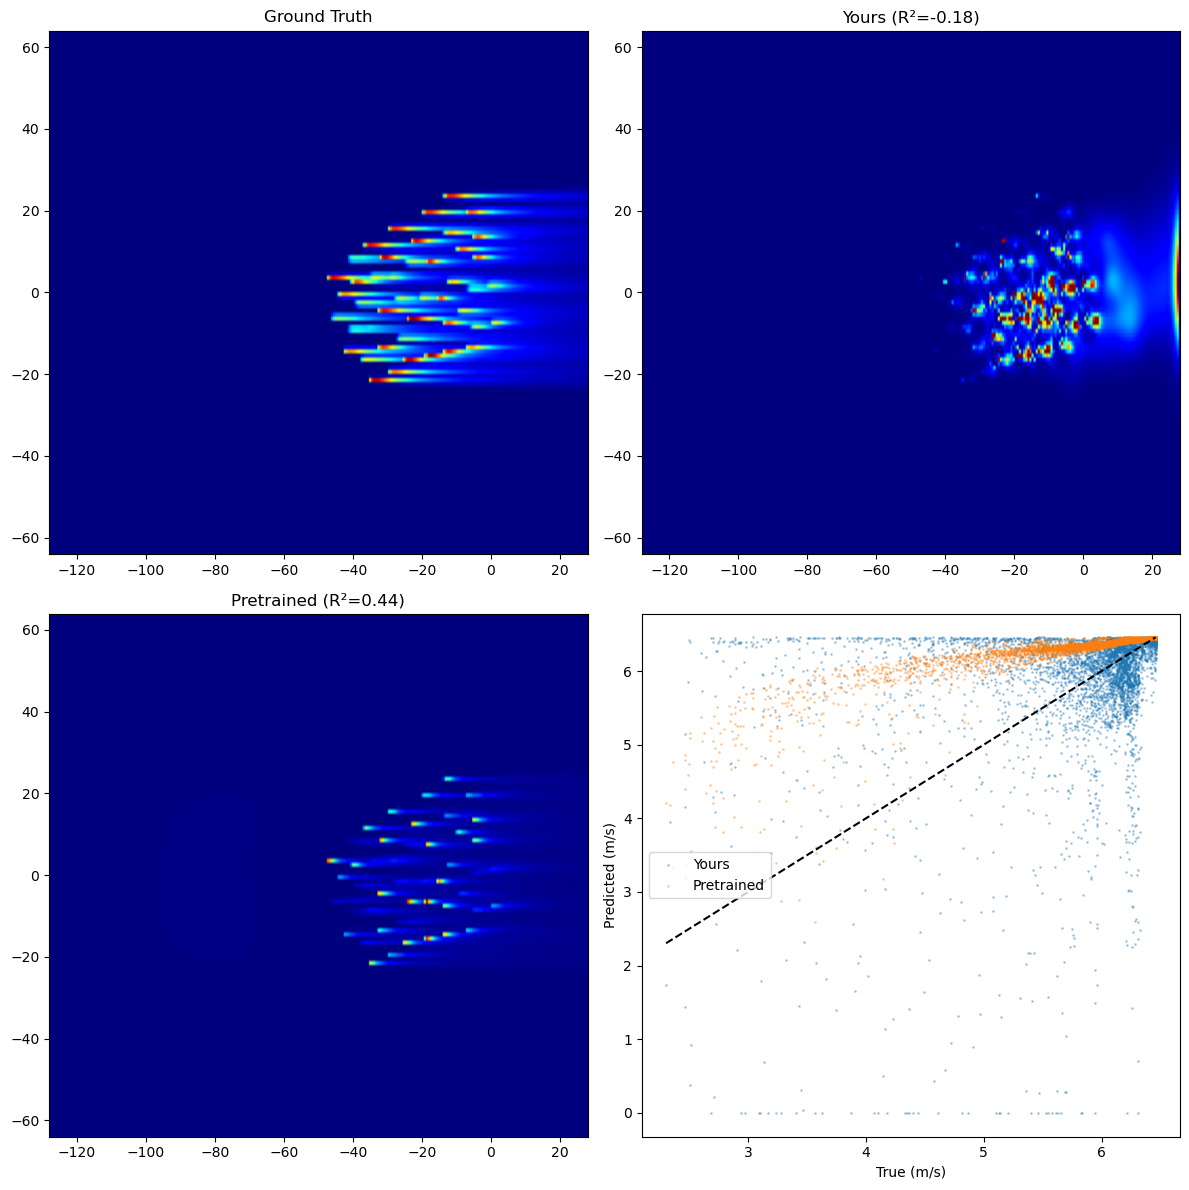

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(test['flow_map'], origin='lower', cmap='jet_r', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
axes[0, 0].set_title('Ground Truth')
axes[0, 1].imshow(my_pred, origin='lower', cmap='jet_r', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
axes[0, 1].set_title(f'Yours (R²={my_m["r2"]:.2f})')
axes[1, 0].imshow(pre_pred, origin='lower', cmap='jet_r', vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
axes[1, 0].set_title(f'Pretrained (R²={pre_m["r2"]:.2f})')

axes[1, 1].scatter(test['flow_map'].flatten(), my_pred.flatten(), s=1, alpha=0.3, label='Yours')
axes[1, 1].scatter(test['flow_map'].flatten(), pre_pred.flatten(), s=1, alpha=0.3, label='Pretrained')
axes[1, 1].plot([vmin, vmax], [vmin, vmax], 'k--')
axes[1, 1].legend()
axes[1, 1].set_xlabel('True (m/s)')
axes[1, 1].set_ylabel('Predicted (m/s)')
# axes[3].set_aspect('equal')
plt.tight_layout()

## Summary

- **Layout generation**: Polygon boundary + Poisson disk sampling
- **Rasterization**: Bilinear interpolation of turbine positions
- **Normalization**: Min-max for labels, log transform for outputs
- **Model**: ARUNet with FiLM conditioning on wind parameters
- More data and training → better predictions